In [53]:
import jax
import jax.numpy as jnp
import numpyro
import arviz as az
import numpy as np
import scipy.stats as stats
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
true_w1 = 1.5
true_w2 = 0.8

In [451]:
N=1000
x_data = np.random.uniform(-5, 5, size=N)
y_data = true_w1 * x_data + true_w2 + np.random.normal(0., 1., size=N)

In [466]:
x_plot_data = np.linspace(-5, 5, 1000)
y_plot_data = true_w1 * x_plot_data + true_w2

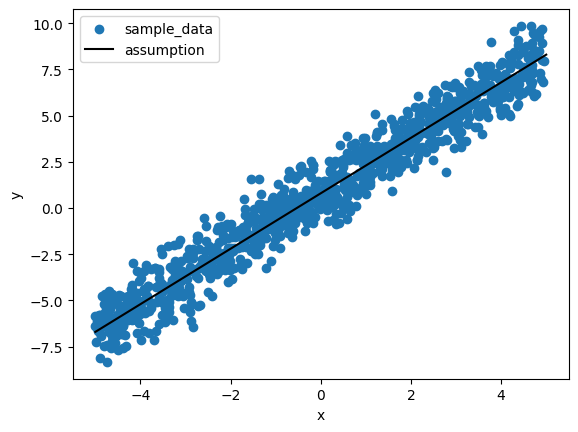

In [467]:
plt.scatter(x=x_data, y=y_data, marker='o', label='sample_data')
plt.plot(x_plot_data, y_plot_data, color='black', label='assumption')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [468]:
def model(x,y = None):
    #推論対象とするパラメータの事前分布
    w1 = numpyro.sample('w1', numpyro.distributions.Normal(0,10))
    w2 = numpyro.sample('w2', numpyro.distributions.Normal(0,10))
    epsilon= numpyro.sample('epsilon', numpyro.distributions.HalfCauchy(5))
       
    with numpyro.plate('data', len(x)):
         y_pred = numpyro.sample('y_pred', numpyro.distributions.Normal(w1* x + w2, epsilon), obs = y)

In [469]:
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=100, num_samples=4000, num_chains=4)

/tmp/ipykernel_14/1601749188.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(kernel, num_warmup=100, num_samples=4000, num_chains=4)


In [470]:
#観測データ(x_data,y_data）でMCMCを実施
mcmc.run(jax.random.PRNGKey(0), x_data, y_data)

sample: 100% 4100/4100 [00:04<00:00, 1001.78it/s, 7 steps of size 6.31e-01. acc. prob=0.93]
sample: 100% 4100/4100 [00:02<00:00, 1609.83it/s, 7 steps of size 7.92e-01. acc. prob=0.91]
sample: 100% 4100/4100 [00:02<00:00, 1603.60it/s, 1 steps of size 5.20e-01. acc. prob=0.96]
sample: 100% 4100/4100 [00:02<00:00, 1601.97it/s, 7 steps of size 5.05e-01. acc. prob=0.96]


array([[<AxesSubplot: title={'center': 'w1'}>,
        <AxesSubplot: title={'center': 'w1'}>],
       [<AxesSubplot: title={'center': 'w2'}>,
        <AxesSubplot: title={'center': 'w2'}>],
       [<AxesSubplot: title={'center': 'epsilon'}>,
        <AxesSubplot: title={'center': 'epsilon'}>]], dtype=object)

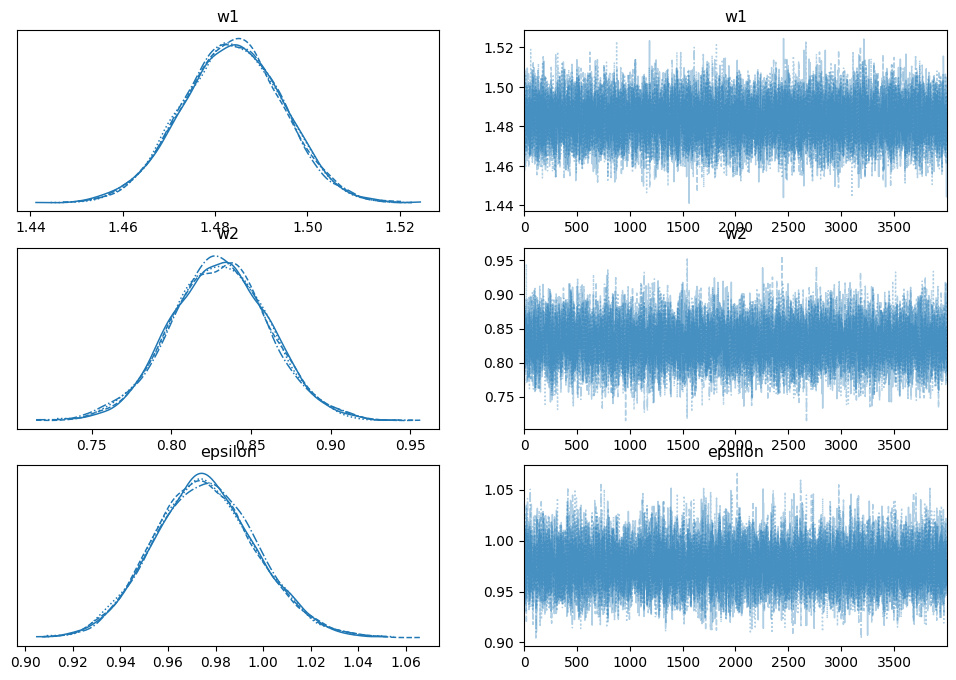

In [472]:
az.plot_trace(mcmc,var_names = ['w1','w2','epsilon'],figsize=(12,8))

array([<AxesSubplot: title={'center': 'w1'}>,
       <AxesSubplot: title={'center': 'w2'}>], dtype=object)

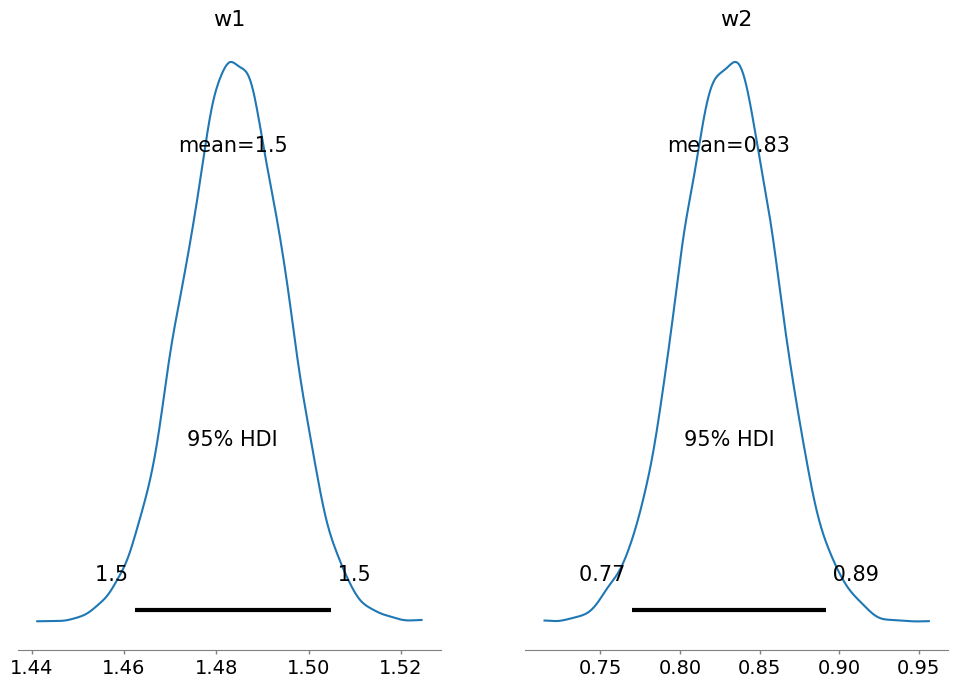

In [473]:
az.plot_posterior(mcmc,hdi_prob = 0.95,var_names=['w1','w2'],figsize=(12,8))

In [474]:
az.summary(mcmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
epsilon,0.976,0.022,0.934,1.016,0.0,0.0,13865.0,10394.0,1.0
w1,1.484,0.011,1.463,1.503,0.0,0.0,17805.0,13010.0,1.0
w2,0.830,0.031,0.771,0.888,0.0,0.0,12508.0,10839.0,1.0


In [475]:
# get_samples()メソッドで結果を一括で取得
posterior_samples = mcmc.get_samples()

In [476]:
#get_samplesの取得結果は辞書型　パラメータの推論結果が格納される
posterior_samples.keys()

dict_keys(['epsilon', 'w1', 'w2'])

In [477]:
#予測用のインスタンスを作成
predictive = numpyro.infer.Predictive(model, posterior_samples)

#パラメータ('epsilon', 'w1', 'w2')以外('y_pred')の確立変巣を予測出力
#引数のxは観測データ(x_data)ではなく新しいデータ(予測したい新たしいデータ)
predictive_samples = predictive(jax.random.PRNGKey(0), x=x_plot_data)

In [478]:
predictive_samples.keys()

dict_keys(['y_pred'])

In [479]:
#1回のサンプルで出力されるyは100(x=100のため)
predictive_samples['y_pred'][1,:].size

1000

(-5.0, 5.0)

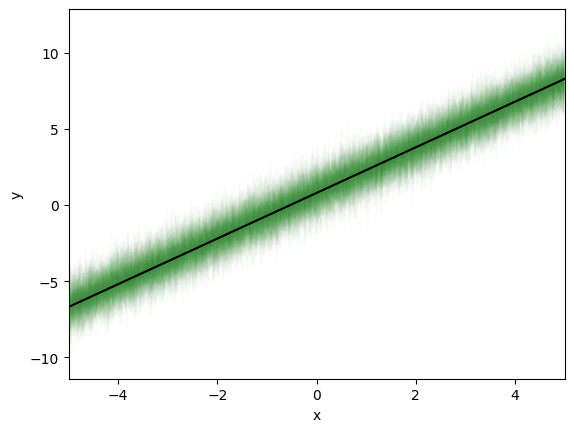

In [489]:
#1000回分のサンプルをプロットする
for i in range(100):
    plt.plot(np.linspace(-5,5,N),predictive_samples['y_pred'][i,:], lw=1, alpha=0.01, color='g', zorder=i)


#真の値の直線をプロット
plt.plot(x_plot_data, y_plot_data, color='black', label='assumption', zorder=i+3)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-5,5)

In [490]:
y_low , y_high = np.percentile(predictive_samples['y_pred'],[2.5, 97.5],axis=0)

Text(0, 0.5, 'y')

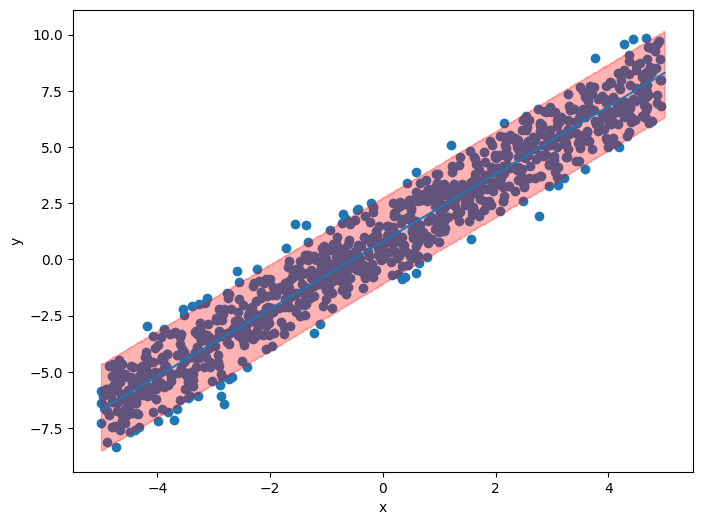

In [498]:
fig,axes = plt.subplots(figsize=(8,6))
axes.plot(x_plot_data,y_plot_data)
#観測データをプロット
axes.scatter(x=x_data, y=y_data, marker='o', label='sample_data', zorder=0)
#予測分布(y_pred)の95%信頼区間を表示
axes.fill_between(x_plot_data, y_low, y_high, color="r", alpha=0.3)
axes.set_xlabel('x')
axes.set_ylabel('y')

Text(0, 0.5, 'percent')

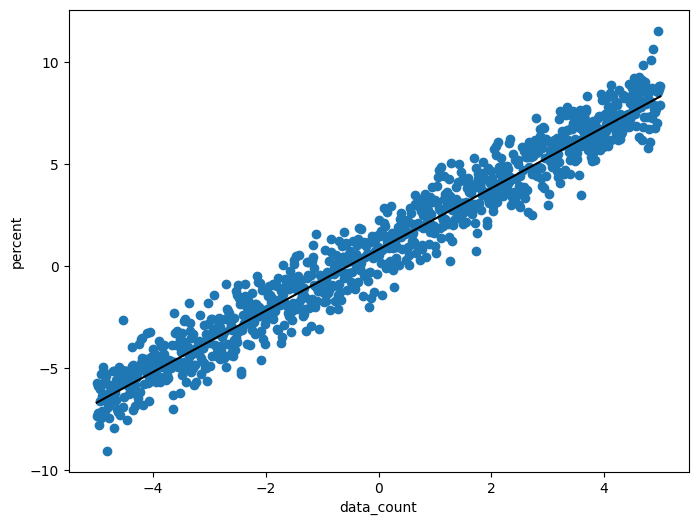

In [497]:
fig,axes = plt.subplots(figsize=(8,6))
#推論されたパラメータから予測されたy_predの１回目のサンプルをプロット
axes.scatter(x=np.linspace(-5,5,N),y=predictive_samples['y_pred'][0,:], marker='o',label='data')
#真の値の線形図をプロット
axes.plot(x_plot_data, y_plot_data, color='black',label='true')
axes.set_xlabel('data_count')
axes.set_ylabel('percent')

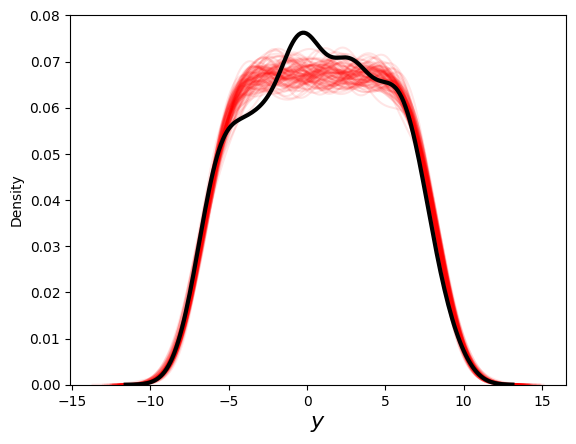

In [494]:
_, ax = plt.subplots()
for y_pred in predictive_samples['y_pred'][0:100]:
    sns.kdeplot(y_pred, alpha=0.1, c='r', ax=ax)
# real data
sns.kdeplot(y_data, linewidth=3, color='k', ax=ax)
    
plt.xlabel('$y$', fontsize=16);